In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [204]:
basePath = "D:\\Documents\\gear_analysis"

In [205]:
anglesDistsToCentroid = pd.read_csv(os.path.join(basePath, "02angles_dist_to_centroid.txt"), delimiter=',', header=None, 
                                   names=['index_angle', 'angle', 'index_distance', 'distance'])

In [206]:
anglesDistsToCentroid.shape

(1942, 4)

In [207]:
angles = anglesDistsToCentroid[['index_angle', 'angle']]
distances = anglesDistsToCentroid[['index_distance', 'distance']]

In [208]:
anglesDistsToCentroid = (angles.merge(distances, 
                                     left_on='index_angle', right_on='index_distance')[['index_angle', 'angle', 'distance']]
    .rename(columns={'index_angle': 'index'}))

In [209]:
anglesDistsToCentroid

,index,angle,distance
0,28,0.010521,62.3055
1,27,0.023708,62.7341
2,26,0.027467,62.9846
3,25,0.029872,63.6164
4,24,0.031602,64.2479
...,...,...,...
1937,33,6.252150,64.2760
1938,32,6.254070,63.6164
1939,31,6.257130,62.9234
1940,30,6.262460,62.4447


In [210]:
innerRadius = pd.read_csv(os.path.join(basePath, "03inner_circle.txt"), delimiter=',', header=None).iloc[0, 2]
outerRadius = pd.read_csv(os.path.join(basePath, "04outer_circle.txt"), delimiter=',', header=None).iloc[0, 2]

In [211]:
anglesDistsToCentroid['inner_radius'] = innerRadius
anglesDistsToCentroid['outer_radius'] = outerRadius

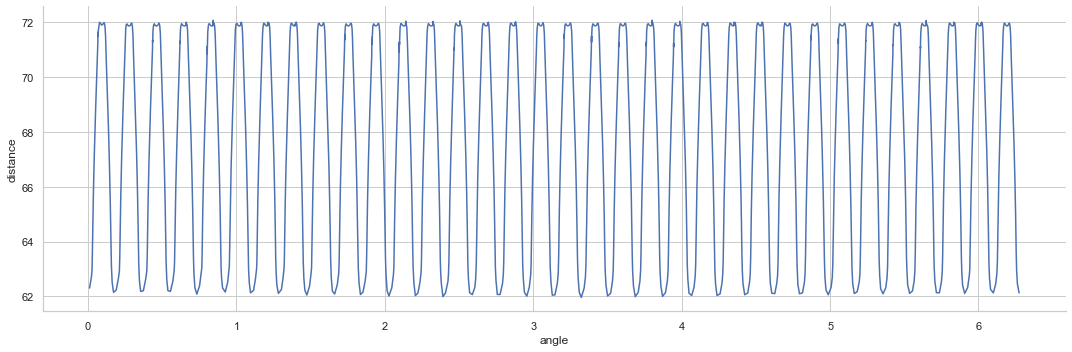

In [212]:
sns.relplot(kind='line', x='angle', y='distance', data=anglesDistsToCentroid, height=5, aspect=3)

In [213]:
anglesDistsToCentroid = pd.melt(anglesDistsToCentroid, id_vars=('index', 'angle'), 
                                value_vars=('distance', 'inner_radius', 'outer_radius'))

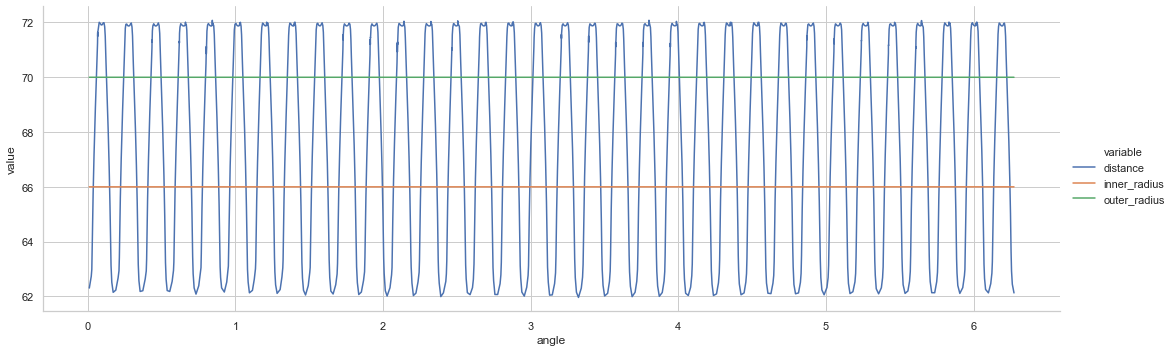

In [214]:
sns.relplot(kind='line', x='angle', y='value', hue='variable', data=anglesDistsToCentroid, height=5, aspect=3)

## Pitch nominals and actuals

In [215]:
leftPitchActual = pd.read_csv(os.path.join(basePath, "05left_pitch_actuals.txt"), delimiter=' ', header=None,
                       names=['u', 'v'])
leftPitchActual['source'] = 'actual'
rightPitchActual = pd.read_csv(os.path.join(basePath, "07right_pitch_actuals.txt"), delimiter=' ', header=None,
                       names=['u', 'v'])
rightPitchActual['source'] = 'actual'

In [216]:
leftPitchNominal = pd.read_csv(os.path.join(basePath, "06left_pitch_nominals.txt"), delimiter=' ', header=None,
                       names=['u', 'v'])
leftPitchNominal['source'] = 'nominal'

In [217]:
leftPitch = pd.concat((leftPitchActual.reset_index(drop=True), leftPitchNominal.reset_index(drop=True)), axis=0)

In [218]:
leftPitch

,u,v,source
0,67.9270,3.14901,actual
1,66.1917,15.57740,actual
2,62.2025,27.47450,actual
3,56.0946,38.43690,actual
4,48.0767,48.08980,actual
...,...,...,...
29,43.4416,-52.31470,nominal
30,52.3147,-43.44160,nominal
31,59.4063,-33.08910,nominal
32,64.4749,-21.60980,nominal


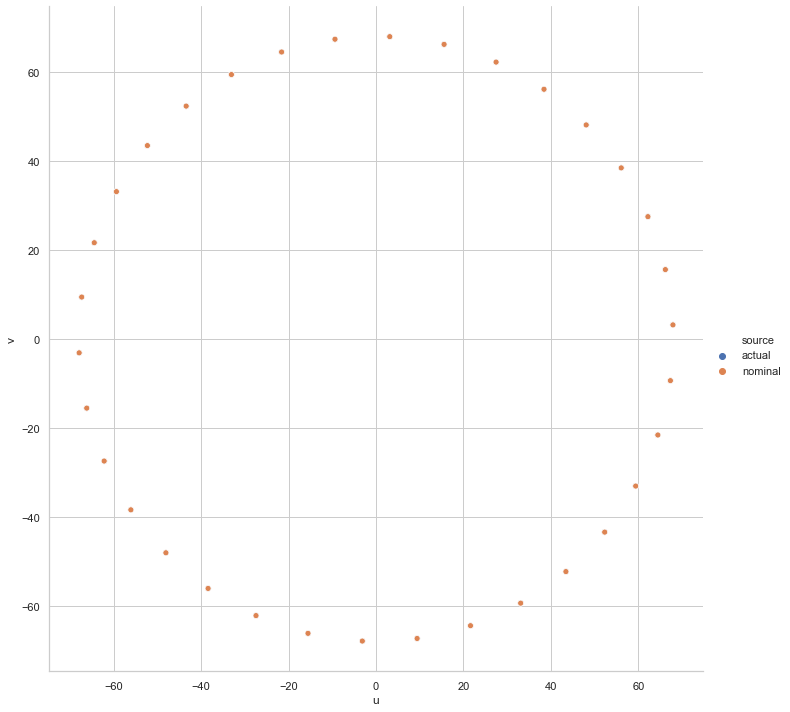

In [219]:
fg = sns.relplot(kind='scatter', x='u', y='v', hue='source', data=leftPitch, height=10, aspect=1)
axes = fg.axes

In [220]:
actual = pd.read_csv(os.path.join(basePath, "10all_teeth_actuals.txt"), delimiter=' ', header=None,
                       names=['u', 'v'])
actual['source'] = 'actual'
nominal = pd.read_csv(os.path.join(basePath, "09nominals_all_teeth.txt"), delimiter=' ', header=None,
                       names=['u', 'v'])
nominal['source'] = 'nominal'

In [221]:
pitchRadius = pd.read_csv(os.path.join(basePath, "11pitch_radius.txt"), header=None).iloc[0, 0]
pitchRadius

68

In [222]:
phi = np.linspace(0, 2 * np.pi, 1000, True)
pitchCircle = pd.DataFrame.from_dict({'u': pitchRadius * np.cos(phi), 'v': pitchRadius * np.sin(phi), 'source': 'pitch'})

In [223]:
leftPitchActual['source'] = 'actual_pitch'
rightPitchActual['source'] = 'actual_pitch'

In [224]:
flanks = pd.concat((actual.reset_index(drop=True), nominal.reset_index(drop=True),
                       pitchCircle.reset_index(drop=True), 
                       leftPitchActual.reset_index(drop=True), rightPitchActual.reset_index(drop=True)), axis=0)

(2, 4)

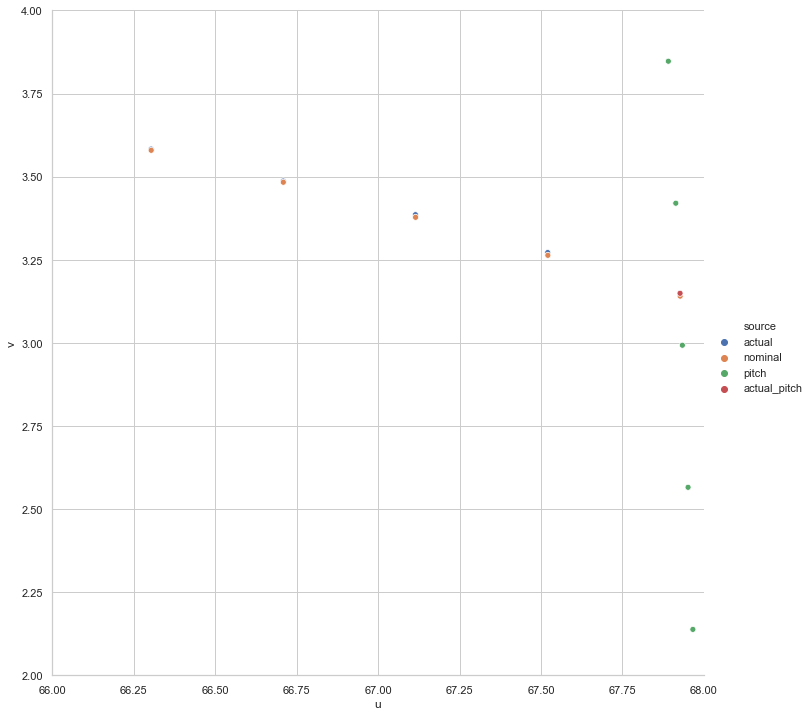

In [225]:
fg = sns.relplot(kind='scatter', x='u', y='v', hue='source', data=flanks, height=10, aspect=1)
axes = fg.axes
axes[0, 0].set_xlim(66, 68)
axes[0, 0].set_ylim(2, 4)

In [226]:
flanks['angle'] = np.arctan2(flanks['v'], flanks['u']) + 2 * np.pi
flanks.loc[flanks['angle'] >= 2 * np.pi, 'angle'] = flanks.loc[flanks['angle'] >= 2 * np.pi, 'angle'] - 2 * np.pi
flanks['distance'] = np.sqrt(flanks['u'] ** 2 + flanks['v'] ** 2)

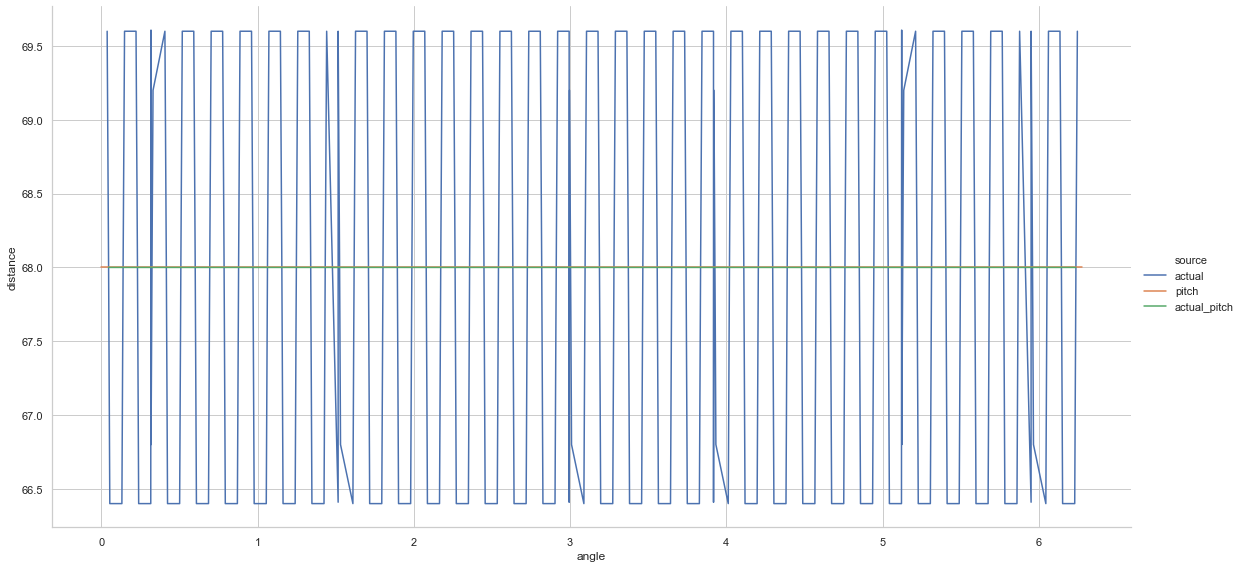

In [227]:
fg = sns.relplot(kind='line', x='angle', y='distance', hue='source', 
                 data=flanks.query("angle<50 & (source!='nominal')"), height=8, aspect=2)

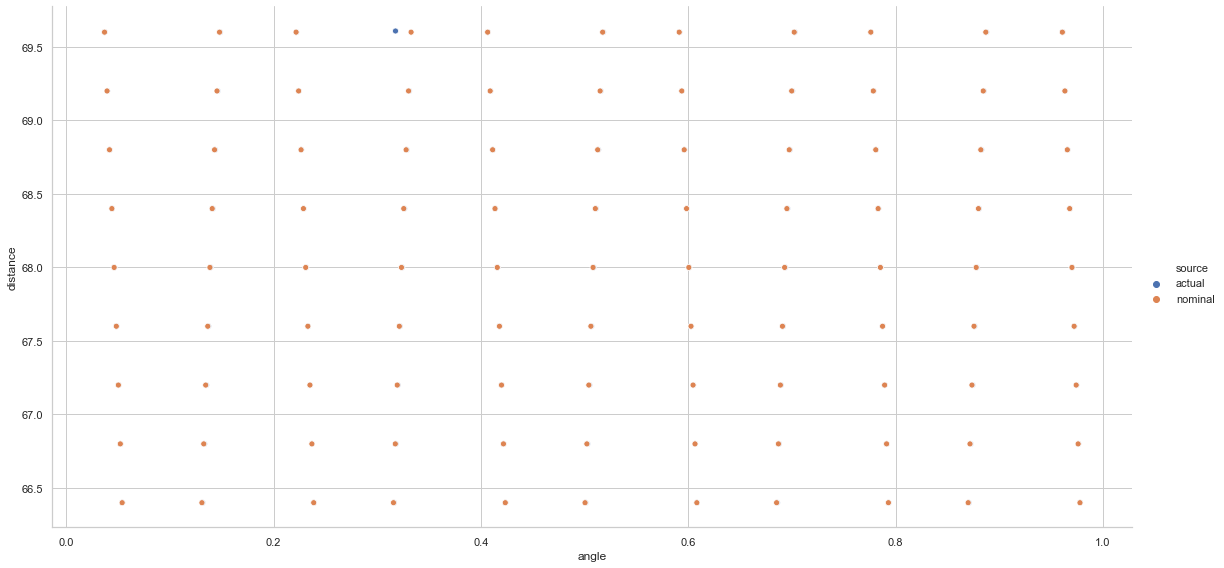

In [228]:
fg = sns.relplot(kind='scatter', x='angle', y='distance', hue='source', 
                 data=flanks.query("angle<1 & (source=='nominal' | source=='actual')"), height=8, aspect=2)

In [229]:
flankActuals = flanks.query("source=='actual'").sort_values(by=['angle'])
flankNominals = flanks.query("source=='nominal'").sort_values(by=['angle'])

In [230]:
flankDeviations = pd.DataFrame.from_dict({'angle': flankNominals['angle'], 
                                          'deviation': flankActuals['distance'] - flankNominals['distance']})

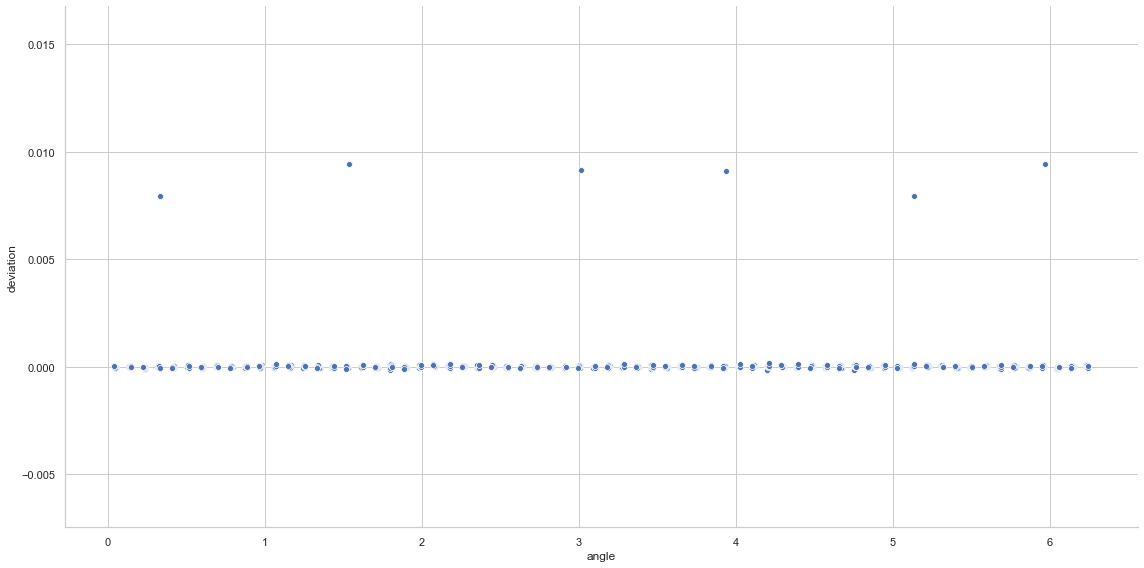

In [231]:
sns.relplot(kind='scatter', x='angle', y='deviation',
            #data=flankDeviations.query("angle < -2"), 
            data=flankDeviations,
            height=8, aspect=2)

In [232]:
pitchNominals = flankNominals.query(
    'abs(distance - {}) < 1e-4'.format(pitchRadius)).sort_values(by='angle').reset_index(drop=True)

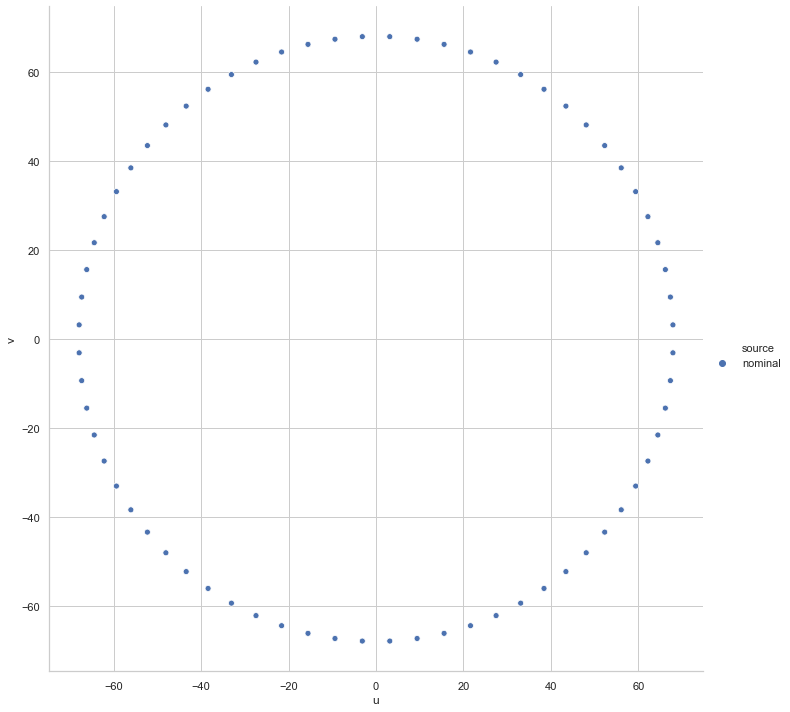

In [233]:
sns.relplot(kind='scatter', x='u', y='v', hue='source', data=pitchNominals, height=10, aspect=1)

In [234]:
teethNumber = np.int32(pitchNominals.shape[0] / 2)

In [235]:
toothWidthNominal = pd.DataFrame.from_dict({ 'tooth_id': np.zeros((teethNumber,), dtype=np.float64), 
                                            'width': np.zeros((teethNumber,), dtype=np.float64), 
                                            'deviation': np.zeros((teethNumber,), dtype=np.float64)
                                           })

In [236]:
pitchNominals.shape[0]

68

In [237]:
Sn = 6.19

In [238]:
def arcLen(angleA, angleB, radius):
    return (angleB - angleA) * radius;

def computeToothThickness(pitchPoints, nominalThickness = None):
    
    teethNumber = np.int32(pitchPoints.shape[0] / 2)
    #print("teeth: {}".format(teethNumber))
    toothThicknessValues = pd.DataFrame.from_dict({ 'tooth_id': np.zeros((teethNumber,), dtype=np.float64), 
                                            'width': np.zeros((teethNumber,), dtype=np.float64), 
                                            'deviation': np.zeros((teethNumber,), dtype=np.float64)
                                           })
    
    for i in np.arange(0, teethNumber):
        angleA = 0.0
        distanceA = 0.0
        if i == 0:
            angleA = pitchPoints.loc[teethNumber * 2 - 1, 'angle'] - 2 * np.pi
            distanceA = pitchPoints.loc[teethNumber * 2 - 1, 'distance']
        else:
            angleA = pitchPoints.loc[2 * i - 1, 'angle']
            distanceA = pitchPoints.loc[2 * i - 1, 'distance']
        angleB = pitchPoints.loc[2 * i, 'angle']
        distanceB = pitchPoints.loc[2 * i, 'distance']
        pitchRadius = 0.5 * (distanceA + distanceB)
        toothThickness = arcLen(angleA, angleB, pitchRadius)
        #print("Tooth {}: angles between {} and {}: pitchRadius {} arc {}".format(i, angleA, angleB, 
        #                                                                    pitchRadius, toothThickness))
        toothThicknessValues.loc[i, 'tooth_id'] = i
        toothThicknessValues.loc[i, 'width'] = toothThickness
        if nominalThickness:
            toothThicknessValues.loc[i, 'deviation'] = toothThickness - nominalThickness
            
    return toothThicknessValues
    



#for i in np.arange(0, teethNumber):
#    angleA = 0.0    
#    if i == 0:
#        angleA = pitchNominals.loc[teethNumber * 2 - 1, 'angle'] - 2 * np.pi
#    else:
#        angleA = pitchNominals.loc[2 * i - 1, 'angle']
#   
#    angleB = pitchNominals.loc[2 * i, 'angle']
#    toothWidth = arcLen(angleA, angleB, pitchRadius)
#    
#    #print("Tooth {}: angles between {} and {}:  arc {}".format(i, angleA, angleB, toothWidth))
#    
#    toothWidthNominal.loc[i, 'tooth_id'] = i
#    toothWidthNominal.loc[i, 'width'] = toothWidth
#    toothWidthNominal.loc[i, 'deviation'] = toothWidth - Sn
        

In [239]:
toothWidthNominal = computeToothThickness(pitchNominals, Sn)

In [240]:
toothWidthNominal

,tooth_id,width,deviation
0,0.0,6.283195,0.093195
1,1.0,6.283147,0.093147
2,2.0,6.283159,0.093159
3,3.0,6.283212,0.093212
4,4.0,6.283168,0.093168
5,5.0,6.283169,0.093169
6,6.0,6.283224,0.093224
7,7.0,6.283215,0.093215
8,8.0,6.283175,0.093175
9,9.0,6.283175,0.093175


In [241]:
splineActuals = flankActuals[['angle', 'distance']].copy()
rawActuals = anglesDistsToCentroid.query("variable=='distance'")[['angle', 'value']].copy()

In [242]:
splineActuals['source'] = 'spline_actual'
rawActuals['source'] = 'raw_actual'

In [243]:
rawActuals.rename(columns={'value': 'distance'}, inplace=True)

In [244]:
rawActuals

,angle,distance,source
0,0.010521,62.3055,raw_actual
1,0.023708,62.7341,raw_actual
2,0.027467,62.9846,raw_actual
3,0.029872,63.6164,raw_actual
4,0.031602,64.2479,raw_actual
...,...,...,...
1937,6.252150,64.2760,raw_actual
1938,6.254070,63.6164,raw_actual
1939,6.257130,62.9234,raw_actual
1940,6.262460,62.4447,raw_actual


In [245]:
pitchActual = pd.concat([leftPitchActual, rightPitchActual], 
                        axis=0).reset_index(drop=True)
pitchActual['angle'] = np.arctan2(pitchActual['v'], pitchActual['u']) + 2 * np.pi
pitchActual.loc[pitchActual['angle'] >= 2 * np.pi, 'angle'] = pitchActual.loc[pitchActual['angle'] >= 2 * np.pi, 'angle'] - 2 * np.pi
pitchActual['distance'] = np.sqrt(pitchActual['u'] ** 2 + pitchActual['v'] ** 2)
pitchActual = pitchActual.sort_values(by='angle').reset_index(drop=True)

In [246]:
pitchActual

,u,v,source,angle,distance
0,67.9270,3.14901,actual_pitch,0.046326,67.999953
1,67.3429,9.43084,actual_pitch,0.139137,68.000051
2,66.1917,15.57740,actual_pitch,0.231132,67.999975
3,64.4640,21.64230,actual_pitch,0.323903,67.999974
4,62.2025,27.47450,actual_pitch,0.415926,67.999994
...,...,...,...,...,...
63,62.2205,-27.43380,actual_pitch,5.867914,68.000029
64,64.4774,-21.60260,actual_pitch,5.959898,68.000055
65,66.2017,-15.53480,actual_pitch,6.052697,67.999964
66,67.3486,-9.38960,actual_pitch,6.144660,67.999989


In [247]:
actuals = pd.concat([splineActuals.reset_index(drop=True), rawActuals.reset_index(drop=True),
                    pitchActual[['angle', 'distance', 'source']]], axis=0)
actuals.loc[actuals['source'] == 'raw_actual', 'angle'] = actuals.loc[actuals['source'] == 'raw_actual', 'angle'] + Sn / pitchRadius
#+ 0.5 * Sn / pitchRadius

(67, 69)

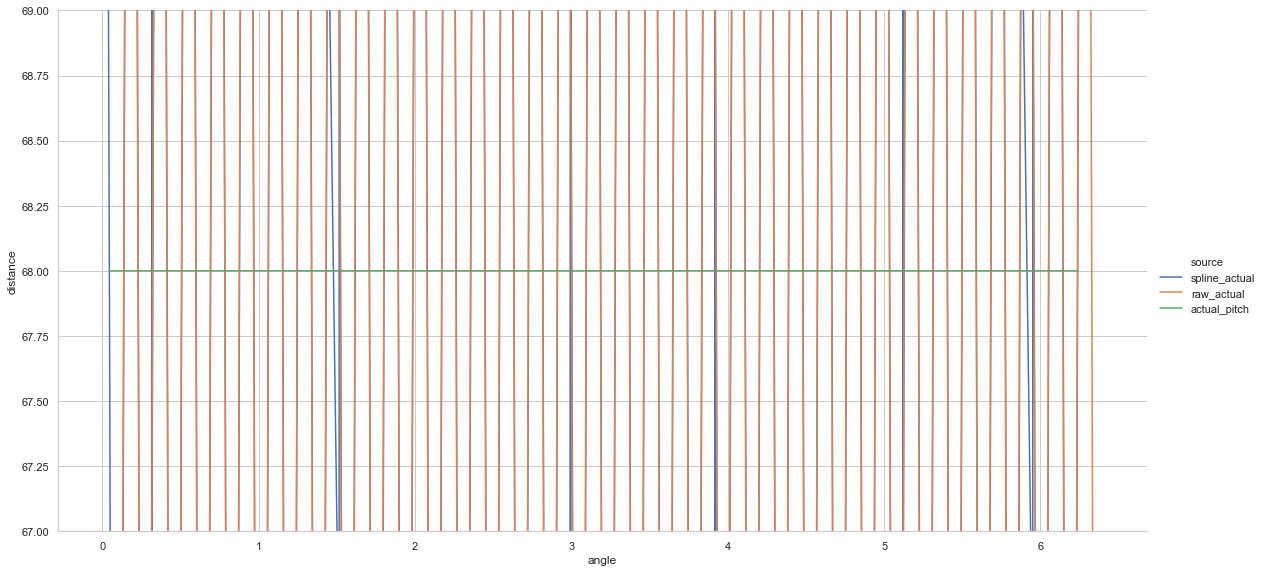

In [248]:
fg = sns.relplot(kind='line', x='angle', y='distance', hue='source', 
                 data=actuals.query("angle < 10"), height=8, aspect=2)
axes = fg.axes
axes[0, 0].set_ylim(pitchRadius - 1, pitchRadius + 1)

In [249]:
pitchActual['radius_deviation'] = pitchActual['distance'] - pitchRadius

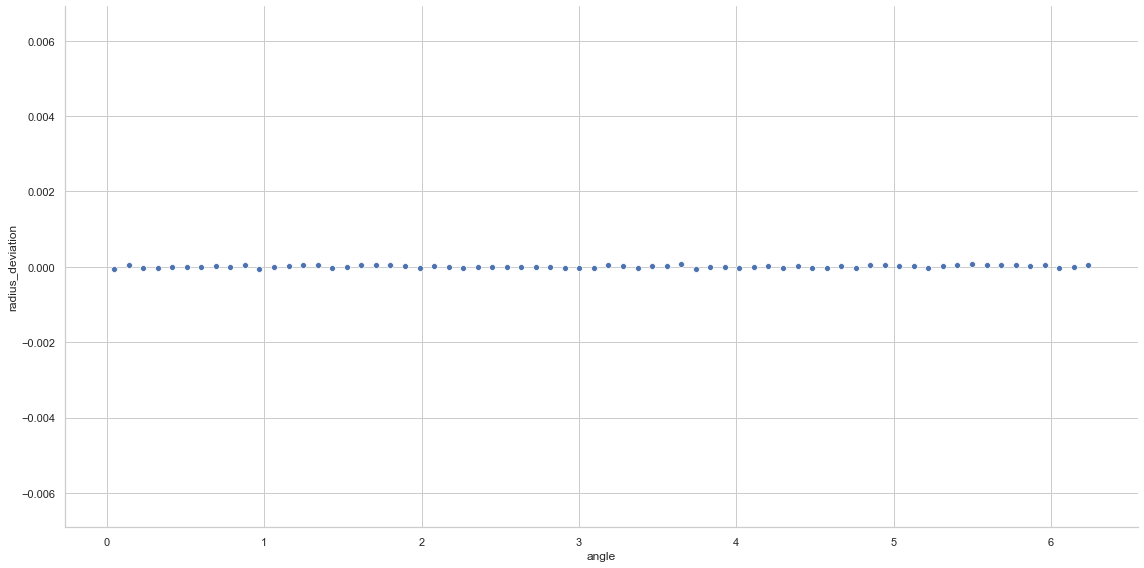

In [250]:
sns.relplot(kind='scatter', x='angle', y='radius_deviation', 
                 data=pitchActual.query("angle < 10"), height=8, aspect=2)

In [251]:
toothThicknessActual = computeToothThickness(pitchActual, Sn)

In [252]:
toothThicknessActual

,tooth_id,width,deviation
0,0.0,6.254615,0.064615
1,1.0,6.255642,0.065642
2,2.0,6.257521,0.067521
3,3.0,6.257058,0.067058
4,4.0,6.256425,0.066425
5,5.0,6.259537,0.069537
6,6.0,6.257576,0.067576
7,7.0,6.255277,0.065277
8,8.0,6.256337,0.066337
9,9.0,6.255197,0.065197


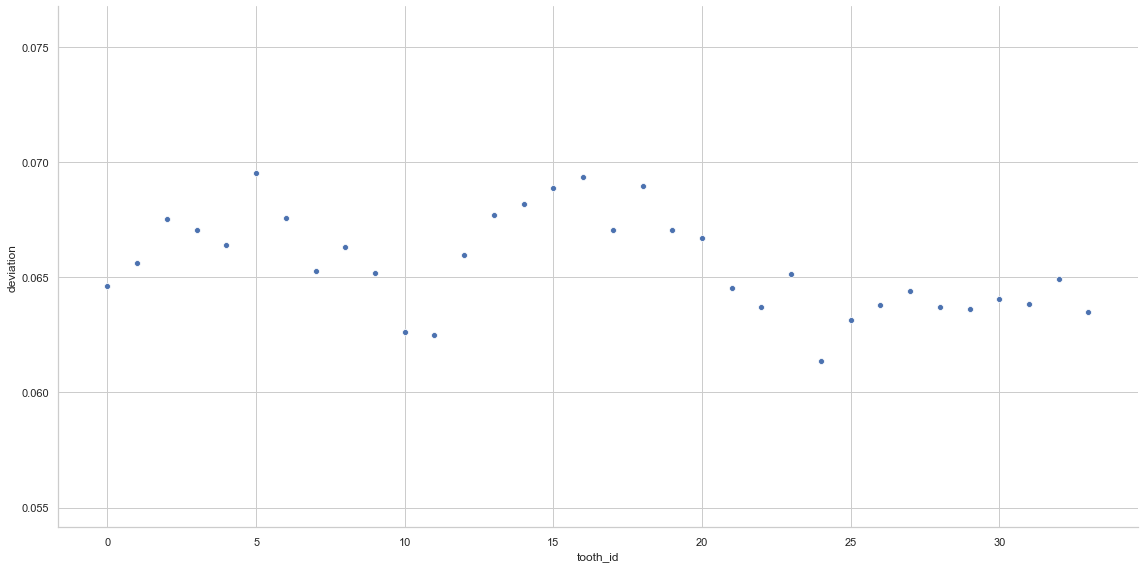

In [253]:
sns.relplot(kind='scatter', x='tooth_id', y='deviation', 
                 data=toothThicknessActual, height=8, aspect=2)

In [254]:
splineActuals

,angle,distance,source
17,0.037068,69.600011,spline_actual
16,0.039521,69.200035,spline_actual
15,0.041859,68.799967,spline_actual
14,0.044128,68.399986,spline_actual
13,0.046326,67.999953,spline_actual
...,...,...,...
4,6.237531,68.000054,spline_actual
5,6.239716,68.400015,spline_actual
6,6.241998,68.800047,spline_actual
7,6.244350,69.199977,spline_actual


In [255]:
splineActuals['u'] = splineActuals['distance'] * np.cos(splineActuals['angle'])
splineActuals['v'] = splineActuals['distance'] * np.sin(splineActuals['angle'])

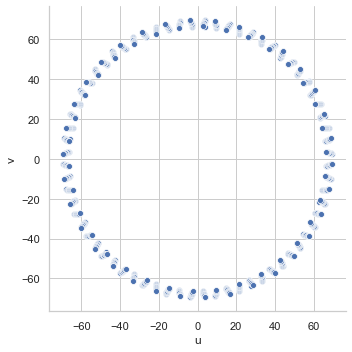

In [256]:
sns.relplot(kind='scatter', x='u', y='v', data=splineActuals, height=5, aspect=1)

In [257]:
actualsVsNominals = pd.concat((splineActuals, flankNominals), axis=0, sort=False)

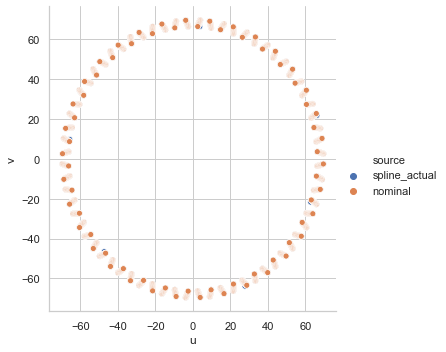

In [258]:
fg = sns.relplot(kind='scatter', x='u', y='v', hue='source', data=actualsVsNominals, height=5, aspect=1)
#axes = fg.axes
#axes[0, 0].set_xlim(-75, -65)
#axes[0, 0].set_ylim(-10, 10)

In [259]:
splineActuals.sort_values(by='angle', inplace=True)
flankNominals.sort_values(by='angle', inplace=True)

In [260]:
splineActuals.shape

(612, 5)

In [261]:
flankNominals.shape

(612, 5)

In [262]:
profileDeviations = pd.DataFrame.from_dict({'angle': splineActuals['angle'], 
                                            'deviation': splineActuals['distance'] - flankNominals['distance']})

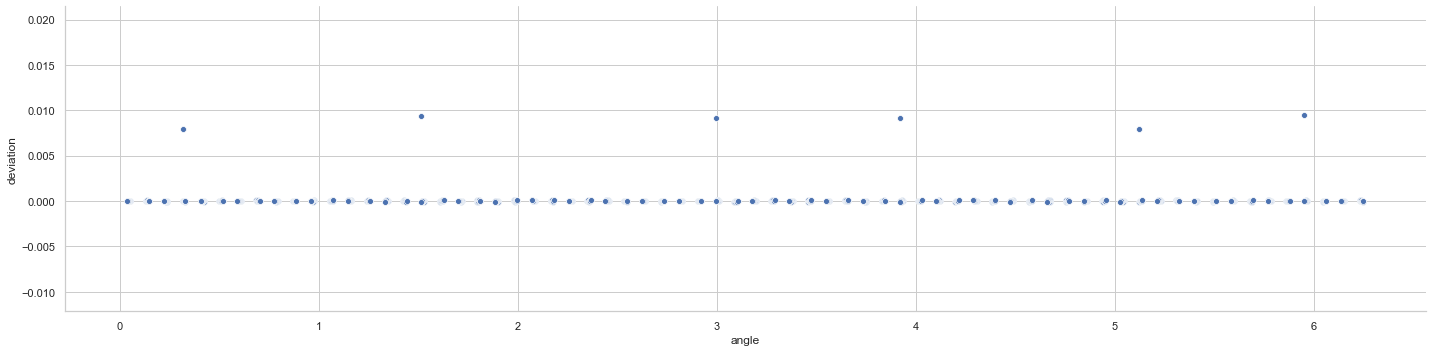

In [263]:
sns.relplot(kind='scatter', x='angle', y='deviation', data=profileDeviations, height=5, aspect=4)

In [264]:
np.min(profileDeviations['deviation'])

-0.00014749710805972427

In [265]:
np.max(profileDeviations['deviation'])

0.009444782871270263

In [266]:
np.degrees(0.3491)

20.00195662801704